In [80]:
#!pip install gurobipy

In [81]:
##Importando las librerías necesarias
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

In [82]:
###Índices###

#Definiendo el conjunto de productos
productos = ['MT','CT','MHT','HT','TE','TT','FT','PT','BT','RT','TA','TiE','TiEE','FTi','MTi','FC','RC','TC','MM','CM','MHM']
#Definiendo el conjunto de productos con destino social
productos_social = ['MT','CT','MHT','TiEE','FTi','MM','CM']
#Definiendo el conjunto de materias primas necesarias
materias_primas = ['T','Ti','C','M']
#Definiendo el conjunto de procesos de producción necesarios para la fabricación de los productos
procesos = ['Lim','Evis','Coc','Emp']

###Parámetros###

#Definiendo la utilidad marginal esperada en pesos por cada tonelada fabricada de producto 
utilidad_marginal = {
    'MT': 703.24,
    'CT': 717.98,
    'MHT': 478.33,
    'HT': -863.73,
    'TE': 29,
    'TT': 848,
    'FT': 589.37,
    'PT': 2727.25,
    'BT': 3365.58,
    'RT': 2959.38,
    'TA': 632.88,
    'TiE': 291.1,
    'TiEE': 321.70,
    'FTi': 280.48,
    'MTi': -609.14,
    'FC': -854.65,
    'RC': -256.04,
    'TC': 942.38,
    'MM': 865.57,
    'CM': 733.5,
    'MHM': -458.98
}
#Definiendo el coeficiente técnico de norma de consumo de toneladas de materias primas por cada tonelada de producto fabricado
coef_tecn_prod_mat_prima = {
    'T': {'MT':1.2,'CT':0.8,'MHT':1,'HT':1.1,'TE':1.5,'TT':0.9,'FT':2,'PT':1.5,'BT':1.6,'RT':1,'TA':1.1,'TiE':0,'TiEE':0,'FTi':0,'MTi':0,'FC':0,'RC':0,'TC':0,'MM':0,'CM':0,'MHM':0},
    'Ti': {'MT':0,'CT':0,'MHT':0,'HT':0,'TE':0,'TT':0,'FT':0,'PT':0,'BT':0,'RT':0,'TA':0,'TiE':1.3,'TiEE':1.5,'FTi':1.2,'MTi':1,'FC':0,'RC':0,'TC':0,'MM':0,'CM':0,'MHM':0},
    'C': {'MT':0,'CT':0,'MHT':0,'HT':0,'TE':0,'TT':0,'FT':0,'PT':0,'BT':0,'RT':0,'TA':0,'TiE':0,'TiEE':0,'FTi':0,'MTi':0,'FC':1.5,'RC':2,'TC':1.2,'MM':0,'CM':0,'MHM':0},
    'M': {'MT':0,'CT':0,'MHT':0,'HT':0,'TE':0,'TT':0,'FT':0,'PT':0,'BT':0,'RT':0,'TA':0,'TiE':0,'TiEE':0,'FTi':0,'MTi':0,'FC':0,'RC':0,'TC':0,'MM':1.1,'CM':1.2,'MHM':1.1}
}
#Definiendo el coeficiente técnico de capacidad instalada de toneladas de productos a fabricar en un mes por cada proceso
coef_tecn_capacidad_instal_product = {
    'Lim': {'MT':600,'CT':800,'MHT':700,'HT':200,'TE':500,'TT':600,'FT':2000,'PT':1500,'BT':600,'RT':1000,'TA':1100,'TiE':300,'TiEE':850,'FTi':1000,'MTi':1000,'FC':1500,'RC':250,'TC':1200,'MM':1000,'CM':1200,'MHM':300},
    'Evis': {'MT':600,'CT':800,'MHT':700,'HT':200,'TE':500,'TT':600,'FT':2000,'PT':1500,'BT':600,'RT':1000,'TA':1100,'TiE':300,'TiEE':850,'FTi':1000,'MTi':1000,'FC':1500,'RC':250,'TC':1200,'MM':1000,'CM':1200,'MHM':300},
    'Coc': {'MT':600,'CT':800,'MHT':700,'HT':200,'TE':500,'TT':600,'FT':2000,'PT':1500,'BT':600,'RT':1000,'TA':1100,'TiE':300,'TiEE':850,'FTi':1000,'MTi':1000,'FC':1500,'RC':250,'TC':1200,'MM':1000,'CM':1200,'MHM':300},
    'Emp': {'MT':600,'CT':800,'MHT':700,'HT':200,'TE':500,'TT':600,'FT':2000,'PT':1500,'BT':600,'RT':1000,'TA':1100,'TiE':300,'TiEE':850,'FTi':1000,'MTi':1000,'FC':1500,'RC':250,'TC':1200,'MM':1000,'CM':1200,'MHM':300}
}
#Definiendo la disponibilidad de materias primas en el mes
disp_mat_prima = {
    'T': 2000,
    'Ti': 1100,
    'C': 500,
    'M': 600
}
#Definiendo el coeficiente de aprovechamiento de la capacidad instalada de cada proceso en el mes
coef_aprov = {
    'Lim': 0.8,
    'Evis': 0.9,
    'Coc': 0.9,
    'Emp': 0.7
}
#Definiendo la demanda mínima a satisfacer de los productos con destino social
demanda_social = {
    'MT': 90,
    'CT' :50,
    'MHT': 40,
    'TiEE': 100,
    'FTi': 60,
    'MM':35,
    'CM':70
}

In [83]:
###Implementacion del modelo###

#Se crea la instancia de un modelo de optimización
problema = gp.Model('Plan de produccion')

#Se definen las variables de decisión (cantidad de toneladas a producir en el mes) indexadas por tipo de producto
vars_prod = problema.addVars(productos, name='Cant._Product')

#Se definen el conjunto de restricciones asociadas a la disponibilidad de materias primas
rest_mat_prim_disp = problema.addConstrs((gp.quicksum(vars_prod[i]*coef_tecn_prod_mat_prima[j][i] for i in productos)<=disp_mat_prima[j] for j in materias_primas),name='Rest. disponibilidad de mat. primas')
#Se definen el conjunto de restricciones asociadas a la capacidad instalada de los procesos de producción
rest_capac_proc = problema.addConstrs((gp.quicksum(vars_prod[i]/coef_tecn_capacidad_instal_product[j][i] for i in productos)<=coef_aprov[j] for j in procesos),name='Rest. capacidad de procesos')
#Se definen el conjunto de restricciones asociadas al cumplimiento de la demanda de productos con destino social
rest_prod_social = problema.addConstrs((vars_prod[i]>=demanda_social[i] for i in list(demanda_social.keys())),name='Rest. de demanda social')

#Se define la función objetivo de maximizar las utilidades marginales totales
funcion_objetivo = gp.quicksum(vars_prod[i]*utilidad_marginal[i] for i in productos)
problema.setObjective(funcion_objetivo,GRB.MAXIMIZE)

#Se le da solución al problema
problema.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-3427U CPU @ 1.80GHz, instruction set [SSE2|AVX]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 15 rows, 21 columns and 112 nonzeros
Model fingerprint: 0x427bcabf
Coefficient statistics:
  Matrix range     [5e-04, 2e+00]
  Objective range  [3e+01, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+03]
Presolve removed 13 rows and 10 columns
Presolve time: 0.02s
Presolved: 2 rows, 11 columns, 21 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7917724e+06   2.645470e+02   0.000000e+00      0s
       3    9.0095292e+05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.03 seconds (0.00 work units)
Optimal objective  9.009529150e+05


### Resultados de la cantidad óptima a producir y su utilidad esperada

,Cant.a producir,Utilidad esperada
MT,90.000000,63291.600000
CT,50.000000,35899.000000
MHT,40.000000,19133.200000
HT,0.000000,-0.000000
TE,0.000000,0.000000
TT,0.000000,0.000000
FT,0.000000,0.000000
PT,239.065126,651990.365021
BT,0.000000,0.000000
RT,0.000000,0.000000


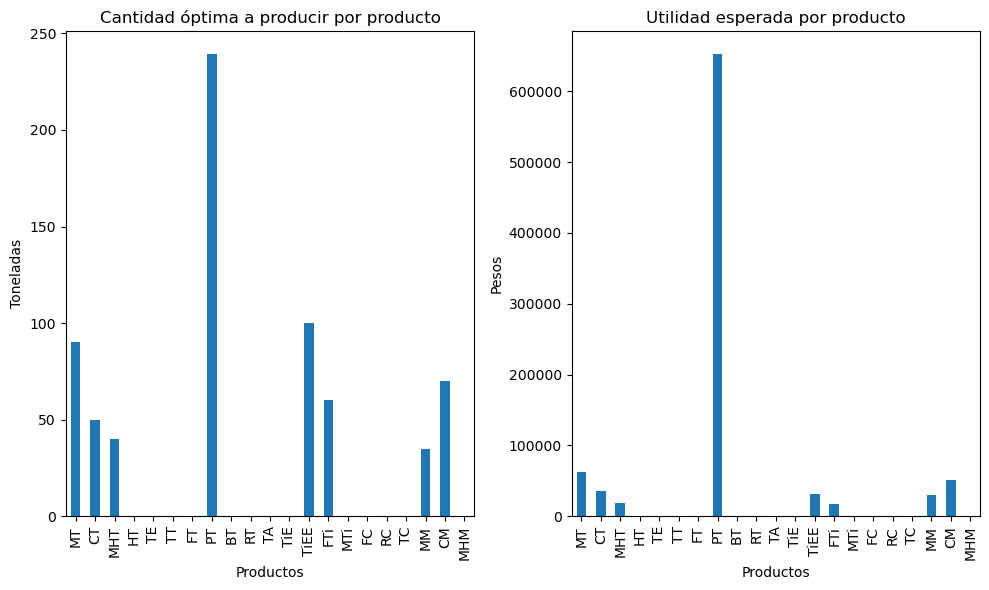

In [84]:
### Accediendo a los resultados ###

plan_produc = [vars_prod[i].x for i in productos]
utilidad = [vars_prod[i].x * utilidad_marginal[i] for i in productos]
df_plan = pd.DataFrame(index=productos,columns=['Cant.a producir'],data=plan_produc)
df_plan['Utilidad esperada'] = utilidad
display(Markdown("### Resultados de la cantidad óptima a producir y su utilidad esperada"))
display(df_plan)
fig,ax=plt.subplots(1,2,figsize=(10,6))
df_plan['Cant.a producir'].plot(kind='bar',ax=ax[0])
df_plan['Utilidad esperada'].plot(kind='bar',ax=ax[1])
ax[0].set_title('Cantidad óptima a producir por producto')
ax[1].set_title('Utilidad esperada por producto')
ax[0].set_xlabel("Productos")
ax[1].set_xlabel("Productos")
ax[0].set_ylabel("Toneladas")
ax[1].set_ylabel("Pesos")
plt.tight_layout()
fig.savefig('results/results_plan.png')

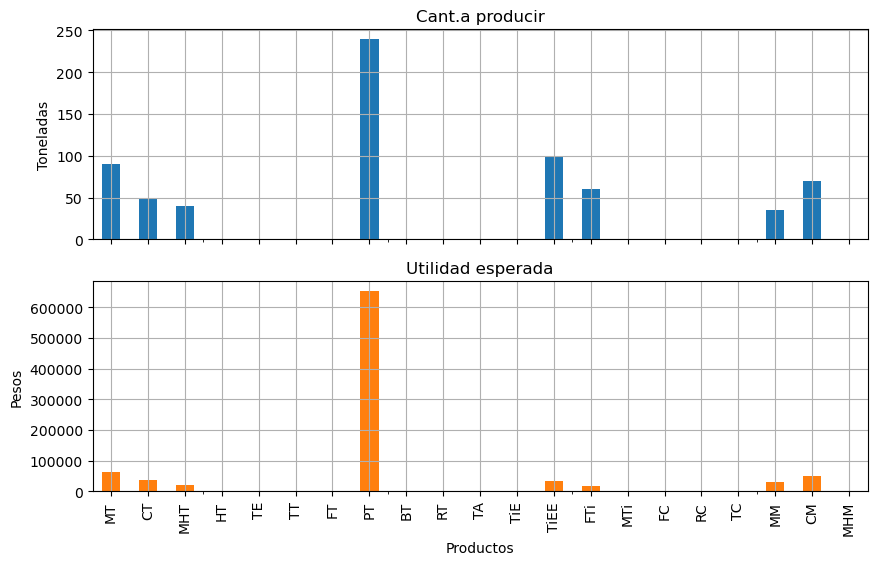

In [85]:
axes = df_plan.plot(kind='bar',subplots=True,figsize=(10,6),xlabel='Productos',legend=False,grid=True)
axes[0].set_ylabel('Toneladas')
axes[1].set_ylabel('Pesos')
fig1 = axes[0].get_figure()
fig1.savefig('results/results_plan2.png')

### Resultados del análisis postoptimal

,Disponibilidad,Precio sombra,Holgura
Rest. disponibilidad de mat. primas[T],2000.0,0.000000e+00,1453.402311
Rest. disponibilidad de mat. primas[Ti],1100.0,0.000000e+00,878.000000
Rest. disponibilidad de mat. primas[C],500.0,0.000000e+00,500.000000
Rest. disponibilidad de mat. primas[M],600.0,0.000000e+00,477.500000
Rest. capacidad de procesos[Lim],0.8,0.000000e+00,0.100000
Rest. capacidad de procesos[Evis],0.9,0.000000e+00,0.200000
Rest. capacidad de procesos[Coc],0.9,0.000000e+00,0.200000
Rest. capacidad de procesos[Emp],0.7,4.090875e+06,0.000000
Rest. de demanda social[MT],90.0,-6.114885e+03,0.000000
Rest. de demanda social[CT],50.0,-4.395614e+03,0.000000


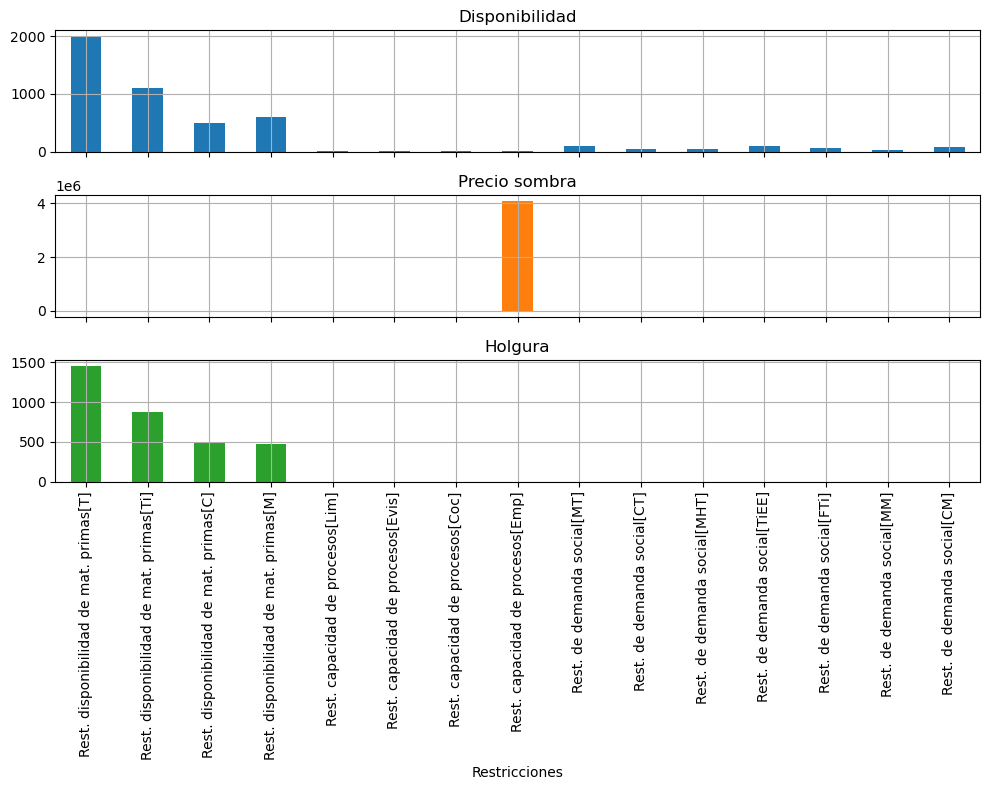

In [86]:
### Accediendo a los resultados del análisis postoptimal

rest = []
disp = []
shadow_price = []
holgura = []

for constr in problema.getConstrs():
    rest.append(constr.ConstrName)
    disp.append(constr.RHS)
    shadow_price.append(constr.Pi)
    holgura.append(constr.Slack)

df_post_optimal = pd.DataFrame(index=rest,columns=['Disponibilidad','Precio sombra','Holgura'])
df_post_optimal['Disponibilidad'] = disp
df_post_optimal['Precio sombra'] = shadow_price
df_post_optimal['Holgura'] = holgura

display(Markdown("### Resultados del análisis postoptimal"))
display(df_post_optimal)

axes = df_post_optimal.plot(kind='bar',subplots=True,figsize=(10,8),xlabel='Restricciones',legend=False,grid=True)
plt.tight_layout()

fig2 = axes[0].get_figure()
fig2.savefig('results/results_postoptimal.png')

In [87]:
### Gurdando los resultados ###
problema.write('results/output.sol')